# Persona Similarity vs. Success Rate Analysis

## Objective
Test the hypothesis: **Does persona similarity between Hint-giver (Codemaster) and Guesser lead to higher success in Codenames?**

## Methodology
We compute two metrics:
1. **Semantic Embedding Similarity** (Metric 1): Cosine similarity of persona descriptions using embeddings
2. **LLM-as-a-Judge Compatibility** (Metric 2): Pre-computed collaborative compatibility scores (1-10)

Then correlate these with:
- Win Rate
- Average Turns to Win

## Data Sources
- `game_logs/`: Raw game results from persona pairs with multiple runs each
- `personas.json`: Natural language descriptions of personas
- `persona_similarity.csv`: Pre-computed LLM-as-a-Judge compatibility scores

## Configuration
- **MAX_PERSONA_ID**: Configurable limit to match experiment settings (filters out higher persona IDs)

## 1. Setup and Imports

In [15]:
import json
import os
import glob
import re
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cosine

# Embedding model
from sentence_transformers import SentenceTransformer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ===== CONFIGURATION =====
MAX_PERSONA_ID = 10  # Set to match your RunFullExperiment.ipynb configuration
print(f"Analysis configured for personas 1-{MAX_PERSONA_ID}")

Analysis configured for personas 1-10


## 2. Load and Parse Game Logs

Parse all game logs from `game_logs/` directory and aggregate performance by persona pair.

In [16]:
def parse_game_filename(filename):
    """
    Extract codemaster and guesser persona IDs from filename.
    Pattern: full_persona_exp_TIMESTAMP_cm{X}_g{Y}_game{N}.json
    Returns: (codemaster_id, guesser_id, game_number)
    """
    pattern = r'cm([^_]+)_g([^_]+)_game(\d+)\.json'
    match = re.search(pattern, filename)
    if match:
        cm_id = match.group(1)  # Could be 'None' or a number
        g_id = match.group(2)
        game_num = int(match.group(3))
        
        # Convert to int if not 'None'
        cm_id = None if cm_id == 'None' else int(cm_id)
        g_id = None if g_id == 'None' else int(g_id)
        
        return cm_id, g_id, game_num
    return None, None, None


def load_game_logs(logs_dir='game_logs', max_persona_id=None):
    """
    Load all game logs and aggregate by persona pair.
    
    Args:
        logs_dir: Directory containing game log files
        max_persona_id: Maximum persona ID to include (filters out higher IDs)
    
    Returns: DataFrame with columns [cm_id, guesser_id, game_num, won, turns, duration]
    """
    game_records = []
    
    log_files = glob.glob(os.path.join(logs_dir, '*.json'))
    print(f"Found {len(log_files)} game log files")
    
    filtered_count = 0
    parsing_errors = 0
    for log_file in log_files:
        filename = os.path.basename(log_file)
        cm_id, g_id, game_num = parse_game_filename(filename)
        
        # Check for actual parsing errors (couldn't extract from filename at all)
        if cm_id is None and g_id is None and game_num is None:
            parsing_errors += 1
            continue
        
        # Filter by max_persona_id if specified
        # Note: We keep baseline games (both None) regardless of max_persona_id
        if max_persona_id is not None:
            if (cm_id is not None and cm_id > max_persona_id) or (g_id is not None and g_id > max_persona_id):
                filtered_count += 1
                continue
        
        try:
            with open(log_file, 'r') as f:
                data = json.load(f)
            
            game_records.append({
                'cm_id': cm_id,
                'guesser_id': g_id,
                'game_num': game_num,
                'won': data.get('won', False),
                'turns': data.get('total_turns', 0),
                'duration': data.get('game_duration', 0),
                'end_reason': data.get('end_reason', 'unknown')
            })
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue
    
    df = pd.DataFrame(game_records)
    print(f"\nLoaded {len(df)} game records")
    if parsing_errors > 0:
        print(f"Skipped {parsing_errors} files due to parsing errors")
    if filtered_count > 0:
        print(f"Filtered out {filtered_count} games with persona IDs > {max_persona_id}")
    print(f"Persona pairs (excluding None): {df[(df['cm_id'].notna()) & (df['guesser_id'].notna())].groupby(['cm_id', 'guesser_id']).size().shape[0]}")
    print(f"Baseline (both None): {len(df[(df['cm_id'].isna()) & (df['guesser_id'].isna())])}")
    
    return df


# Load all game data with MAX_PERSONA_ID filter
games_df = load_game_logs(logs_dir='llama_game_logs', max_persona_id=MAX_PERSONA_ID)
games_df.head(10)

Found 80 game log files

Loaded 80 game records
Persona pairs (excluding None): 65
Baseline (both None): 1


,cm_id,guesser_id,game_num,won,turns,duration,end_reason
0,1.0,4.0,0,False,4,184.437967,assassin
1,9.0,5.0,0,False,1,7.467776,assassin
2,3.0,2.0,0,False,2,20.227808,assassin
3,2.0,1.0,0,False,1,5.556036,assassin
4,7.0,2.0,0,False,7,39.799840,assassin
5,9.0,8.0,0,False,4,36.537457,assassin
6,NaN,8.0,0,True,8,527.698413,all_found
7,5.0,9.0,0,False,2,49.349005,assassin
8,5.0,10.0,0,True,14,220.464371,all_found
9,4.0,10.0,0,False,15,230.115997,assassin


In [17]:
# Show distribution of games per persona pair
print("\n=== Games per Persona Pair ===")
pair_counts = games_df[(games_df['cm_id'].notna()) & (games_df['guesser_id'].notna())].groupby(['cm_id', 'guesser_id']).size()
print(f"Min games per pair: {pair_counts.min()}")
print(f"Max games per pair: {pair_counts.max()}")
print(f"Mean games per pair: {pair_counts.mean():.2f}")
print(f"\nSample pairs with counts:")
pair_counts.head(15)


=== Games per Persona Pair ===
Min games per pair: 1
Max games per pair: 1
Mean games per pair: 1.00

Sample pairs with counts:


cm_id  guesser_id
1.0    2.0           1
       3.0           1
       4.0           1
       6.0           1
       10.0          1
2.0    1.0           1
       2.0           1
       4.0           1
       5.0           1
       6.0           1
       8.0           1
3.0    1.0           1
       2.0           1
       4.0           1
       5.0           1
dtype: int64

## 3. Aggregate Performance Metrics by Persona Pair

For each (codemaster, guesser) pair, compute:
- **Win Rate**: % of games won
- **Avg Turns**: Average turns across all games (or only winning games)
- **Avg Turns (Wins Only)**: Average turns for won games only

In [18]:
def aggregate_performance(games_df, exclude_single_none=True):
    """
    Aggregate game performance by persona pair.
    
    Args:
        games_df: DataFrame with individual game results
        exclude_single_none: If True, exclude pairs where exactly one is None
    
    Returns: DataFrame with aggregated metrics per pair
    """
    # Filter based on None policy
    if exclude_single_none:
        # Keep pairs where BOTH have personas OR both are None (baseline)
        mask = (
            ((games_df['cm_id'].notna()) & (games_df['guesser_id'].notna())) |
            ((games_df['cm_id'].isna()) & (games_df['guesser_id'].isna()))
        )
        filtered_df = games_df[mask].copy()
    else:
        filtered_df = games_df.copy()
    
    print(f"Filtered to {len(filtered_df)} games (from {len(games_df)} total)")
    
    # Aggregate by pair
    # IMPORTANT: dropna=False ensures baseline pairs (both None) are included in grouping
    agg_metrics = []
    
    for (cm_id, g_id), group in filtered_df.groupby(['cm_id', 'guesser_id'], dropna=False):
        total_games = len(group)
        wins = group['won'].sum()
        win_rate = wins / total_games if total_games > 0 else 0
        
        avg_turns_all = group['turns'].mean()
        
        # Average turns for won games only
        won_games = group[group['won'] == True]
        avg_turns_wins = won_games['turns'].mean() if len(won_games) > 0 else np.nan
        
        agg_metrics.append({
            'cm_id': cm_id,
            'guesser_id': g_id,
            'total_games': total_games,
            'wins': wins,
            'win_rate': win_rate,
            'avg_turns_all': avg_turns_all,
            'avg_turns_wins_only': avg_turns_wins
        })
    
    agg_df = pd.DataFrame(agg_metrics)
    
    # Separate baseline from persona pairs
    baseline = agg_df[(agg_df['cm_id'].isna()) & (agg_df['guesser_id'].isna())]
    persona_pairs = agg_df[(agg_df['cm_id'].notna()) & (agg_df['guesser_id'].notna())]
    
    print(f"\n=== Aggregated Performance ===")
    print(f"Persona pairs: {len(persona_pairs)}")
    print(f"Baseline pairs: {len(baseline)}")
    
    if len(baseline) > 0:
        print(f"\nBaseline Performance (No Persona):")
        print(baseline[['total_games', 'wins', 'win_rate', 'avg_turns_all', 'avg_turns_wins_only']])
    
    print(f"\nPersona Pair Stats:")
    print(f"  Win Rate: mean={persona_pairs['win_rate'].mean():.3f}, std={persona_pairs['win_rate'].std():.3f}")
    print(f"  Avg Turns (All): mean={persona_pairs['avg_turns_all'].mean():.2f}, std={persona_pairs['avg_turns_all'].std():.2f}")
    print(f"  Avg Turns (Wins): mean={persona_pairs['avg_turns_wins_only'].mean():.2f}, std={persona_pairs['avg_turns_wins_only'].std():.2f}")
    
    return agg_df, baseline, persona_pairs


# Aggregate performance
performance_df, baseline_df, persona_pairs_df = aggregate_performance(games_df)
persona_pairs_df.head(15)

Filtered to 66 games (from 80 total)

=== Aggregated Performance ===
Persona pairs: 65
Baseline pairs: 1

Baseline Performance (No Persona):
    total_games  wins  win_rate  avg_turns_all  avg_turns_wins_only
65            1     0       0.0           11.0                  NaN

Persona Pair Stats:
  Win Rate: mean=0.185, std=0.391
  Avg Turns (All): mean=8.35, std=5.38
  Avg Turns (Wins): mean=13.67, std=3.06


,cm_id,guesser_id,total_games,wins,win_rate,avg_turns_all,avg_turns_wins_only
0,1.0,2.0,1,0,0.0,17.0,NaN
1,1.0,3.0,1,0,0.0,5.0,NaN
2,1.0,4.0,1,0,0.0,4.0,NaN
3,1.0,6.0,1,0,0.0,4.0,NaN
4,1.0,10.0,1,0,0.0,8.0,NaN
5,2.0,1.0,1,0,0.0,1.0,NaN
6,2.0,2.0,1,0,0.0,12.0,NaN
7,2.0,4.0,1,0,0.0,8.0,NaN
8,2.0,5.0,1,0,0.0,7.0,NaN
9,2.0,6.0,1,0,0.0,11.0,NaN


## 4. Metric 1: Semantic Embedding Similarity

Compute cosine similarity between persona descriptions using sentence embeddings.

In [19]:
# Load personas
with open('personas.json', 'r') as f:
    all_personas = json.load(f)

# Filter personas by MAX_PERSONA_ID
personas = {k: v for k, v in all_personas.items() if int(k) <= MAX_PERSONA_ID}

print(f"Loaded {len(all_personas)} total personas from file")
print(f"Using {len(personas)} personas (IDs 1-{MAX_PERSONA_ID}) for analysis")
print(personas['1'][:200] + "...")

Loaded 20 total personas from file
Using 10 personas (IDs 1-10) for analysis
You are Dr. Sarah Kim, a 34-year-old computational linguist specializing in semantic networks and word embeddings. You hold a PhD from MIT and currently work at a tech research lab in San Francisco. Y...


In [20]:
# Load embedding model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
print(f"Loading embedding model: {model_name}")
model = SentenceTransformer(f'{model_name}')

print(f"Model loaded successfully")

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
Model loaded successfully


In [21]:
# Generate embeddings for all personas
persona_embeddings = {}

for persona_id, description in personas.items():
    embedding = model.encode(description, convert_to_numpy=True)
    persona_embeddings[int(persona_id)] = embedding

In [22]:
def compute_embedding_similarity(persona_id_1, persona_id_2, embeddings):
    """
    Compute cosine similarity between two persona embeddings.
    Returns similarity score in [0, 1] (1 = identical, 0 = orthogonal)
    """
    emb1 = embeddings[persona_id_1]
    emb2 = embeddings[persona_id_2]
    
    # Cosine similarity = 1 - cosine distance
    similarity = 1 - cosine(emb1, emb2)
    
    return similarity


# Compute similarity matrix
persona_ids = sorted([int(k) for k in personas.keys()])
n_personas = len(persona_ids)

similarity_matrix = np.zeros((n_personas, n_personas))

for i, pid1 in enumerate(persona_ids):
    for j, pid2 in enumerate(persona_ids):
        similarity_matrix[i, j] = compute_embedding_similarity(pid1, pid2, persona_embeddings)

# Create DataFrame for easier access
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=persona_ids,
    columns=persona_ids
)

print("Embedding Similarity Matrix:")
print(similarity_df.round(3))

Embedding Similarity Matrix:
       1      2      3      4      5      6      7      8      9      10
1   1.000  0.503  0.510  0.257  0.571  0.568  0.456  0.303  0.492  0.298
2   0.503  1.000  0.421  0.429  0.475  0.416  0.374  0.377  0.419  0.389
3   0.510  0.421  1.000  0.258  0.356  0.327  0.361  0.359  0.367  0.441
4   0.257  0.429  0.258  1.000  0.224  0.464  0.455  0.460  0.385  0.499
5   0.571  0.475  0.356  0.224  1.000  0.452  0.453  0.224  0.405  0.324
6   0.568  0.416  0.327  0.464  0.452  1.000  0.602  0.275  0.484  0.328
7   0.456  0.374  0.361  0.455  0.453  0.602  1.000  0.338  0.282  0.433
8   0.303  0.377  0.359  0.460  0.224  0.275  0.338  1.000  0.272  0.451
9   0.492  0.419  0.367  0.385  0.405  0.484  0.282  0.272  1.000  0.290
10  0.298  0.389  0.441  0.499  0.324  0.328  0.433  0.451  0.290  1.000


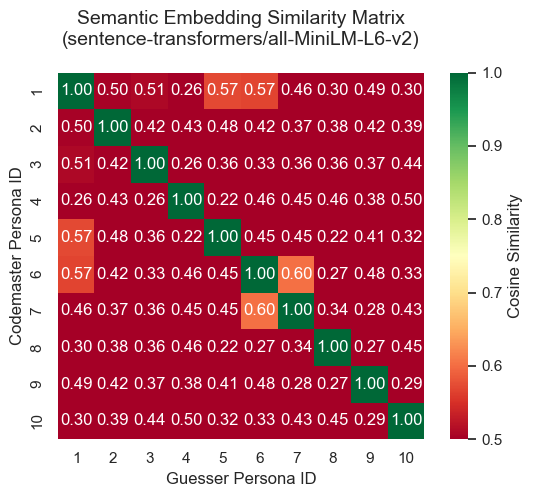


=== Embedding Similarity Stats ===
Mean similarity (off-diagonal): 0.3962
Std similarity: 0.0926
Min similarity: 0.2238
Max similarity: 0.6020


In [36]:
# Visualize embedding similarity matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    similarity_df,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    vmin=0.5,
    vmax=1.0,
    cbar_kws={'label': 'Cosine Similarity'},
    square=True
)
plt.title('Semantic Embedding Similarity Matrix\n(sentence-transformers/all-MiniLM-L6-v2)', fontsize=14, pad=20)
plt.xlabel('Guesser Persona ID', fontsize=12)
plt.ylabel('Codemaster Persona ID', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Embedding Similarity Stats ===")
# Get upper triangle (exclude diagonal)
upper_tri = similarity_matrix[np.triu_indices(n_personas, k=1)]
print(f"Mean similarity (off-diagonal): {upper_tri.mean():.4f}")
print(f"Std similarity: {upper_tri.std():.4f}")
print(f"Min similarity: {upper_tri.min():.4f}")
print(f"Max similarity: {upper_tri.max():.4f}")

## 5. Metric 2: LLM-as-a-Judge Compatibility Scores

Load pre-computed compatibility scores from `persona_similarity.csv`.

In [24]:
# Load LLM-as-a-judge scores
llm_judge_all = pd.read_csv('persona_similarity.csv')

# Filter by MAX_PERSONA_ID
llm_judge_df = llm_judge_all[
    (llm_judge_all['hint_persona_id'] <= MAX_PERSONA_ID) &
    (llm_judge_all['guess_persona_id'] <= MAX_PERSONA_ID)
].copy()

print(f"Loaded {len(llm_judge_all)} total compatibility score entries")
print(f"Using {len(llm_judge_df)} entries for persona IDs 1-{MAX_PERSONA_ID}")
print(f"\nColumns: {llm_judge_df.columns.tolist()}")
print(f"\nCompatibility score range: [{llm_judge_df['compatibility_score'].min()}, {llm_judge_df['compatibility_score'].max()}]")
print(f"Mean: {llm_judge_df['compatibility_score'].mean():.2f}, Std: {llm_judge_df['compatibility_score'].std():.2f}")

llm_judge_df.head(10)

Loaded 100 total compatibility score entries
Using 100 entries for persona IDs 1-10

Columns: ['hint_persona_id', 'guess_persona_id', 'compatibility_score', 'reasoning_tag']

Compatibility score range: [2, 10]
Mean: 6.64, Std: 2.12


,hint_persona_id,guess_persona_id,compatibility_score,reasoning_tag
0,1,1,10,Identical Context (Linguist/Linguist)
1,1,2,3,Clash: Analytical vs. Spontaneous
2,1,3,7,Good: Precision meets Pedagogy
3,1,4,9,Excellent: High Logic/Pattern alignment
4,1,5,8,High: Structured/Architectural thinking
5,1,6,6,Moderate: Semantic vs. Narrative focus
6,1,7,7,Good: Nuance meets Nuance
7,1,8,4,Low: Abstract/Theory vs. Concrete/Safety
8,1,9,8,High: Precision focus
9,1,10,2,Clash: Scientific vs. Abstract/Poetic


In [33]:
# Create compatibility matrix for visualization
compatibility_matrix = np.zeros((n_personas, n_personas))

for _, row in llm_judge_df.iterrows():
    i = row['hint_persona_id'] - 1  # Convert to 0-indexed
    j = row['guess_persona_id'] - 1
    compatibility_matrix[i, j] = row['compatibility_score']

compatibility_df = pd.DataFrame(
    compatibility_matrix,
    index=persona_ids,
    columns=persona_ids
)

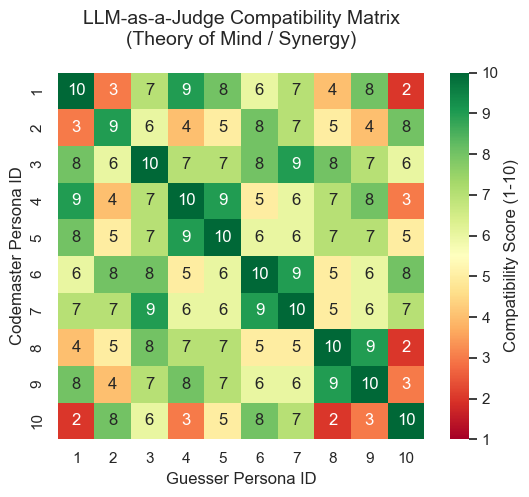

In [35]:
# Visualize compatibility matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    compatibility_df,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn',
    vmin=1,
    vmax=10,
    cbar_kws={'label': 'Compatibility Score (1-10)'},
    square=True
)
plt.title('LLM-as-a-Judge Compatibility Matrix\n(Theory of Mind / Synergy)', fontsize=14, pad=20)
plt.xlabel('Guesser Persona ID', fontsize=12)
plt.ylabel('Codemaster Persona ID', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Merge Similarity Metrics with Performance Data

Create a unified dataset with:
- Game performance (win_rate, avg_turns)
- Embedding similarity (0-1)
- LLM compatibility (1-10)

In [37]:
# Add similarity metrics to performance data
# NOTE: Only persona pairs get similarity metrics; baseline pairs are excluded
analysis_data = []

for _, row in persona_pairs_df.iterrows():
    # persona_pairs_df should only contain non-NaN IDs, but let's be safe
    if pd.isna(row['cm_id']) or pd.isna(row['guesser_id']):
        continue  # Skip baseline pairs (shouldn't happen but defensive programming)
    
    cm_id = int(row['cm_id'])
    g_id = int(row['guesser_id'])
    
    # Get embedding similarity
    emb_sim = similarity_df.loc[cm_id, g_id]
    
    # Get LLM compatibility score
    compat_row = llm_judge_df[
        (llm_judge_df['hint_persona_id'] == cm_id) &
        (llm_judge_df['guess_persona_id'] == g_id)
    ]
    
    if len(compat_row) > 0:
        compat_score = compat_row.iloc[0]['compatibility_score']
        reasoning = compat_row.iloc[0]['reasoning_tag']
    else:
        compat_score = np.nan
        reasoning = 'N/A'
    
    analysis_data.append({
        'cm_id': cm_id,
        'guesser_id': g_id,
        'total_games': row['total_games'],
        'wins': row['wins'],
        'win_rate': row['win_rate'],
        'avg_turns_all': row['avg_turns_all'],
        'avg_turns_wins_only': row['avg_turns_wins_only'],
        'embedding_similarity': emb_sim,
        'compatibility_score': compat_score,
        'llm_reasoning': reasoning,
        'is_same_persona': (cm_id == g_id)
    })

analysis_df = pd.DataFrame(analysis_data)

print(f"Created analysis dataset with {len(analysis_df)} persona pairs")
print(f"Note: Baseline pairs (no persona) are excluded from similarity analysis")
print(f"\nMissing compatibility scores: {analysis_df['compatibility_score'].isna().sum()}")

# Sort by win rate
analysis_df_sorted = analysis_df.sort_values('win_rate', ascending=False)

print("\n=== Top 10 Performing Pairs (by Win Rate) ===")
analysis_df_sorted[['cm_id', 'guesser_id', 'win_rate', 'avg_turns_wins_only', 'embedding_similarity', 'compatibility_score', 'llm_reasoning']].head(10)

Created analysis dataset with 65 persona pairs
Note: Baseline pairs (no persona) are excluded from similarity analysis

Missing compatibility scores: 0

=== Top 10 Performing Pairs (by Win Rate) ===


,cm_id,guesser_id,win_rate,avg_turns_wins_only,embedding_similarity,compatibility_score,llm_reasoning
64,10,9,1.0,17.0,0.289511,3,Clash: Art vs. Science
43,7,10,1.0,12.0,0.432701,7,Good: Emotional intelligence
15,3,6,1.0,11.0,0.327419,8,High: Narrative/Educational alignment
53,9,3,1.0,8.0,0.366647,7,Good: Professional standards
13,3,4,1.0,16.0,0.258495,7,Good: Structured explanations
45,8,3,1.0,14.0,0.358551,8,High: Clear instructions preferred
44,8,2,1.0,11.0,0.376998,5,Clash: Safety vs. Risk
20,4,5,1.0,16.0,0.224167,9,Excellent: Structural/Spatial logic
10,2,8,1.0,18.0,0.376998,5,Clash: Risk-taking vs. Safety-first
29,5,10,1.0,14.0,0.323978,5,Moderate: Structure vs. Abstraction


In [38]:
print("\n=== Bottom 10 Performing Pairs (by Win Rate) ===")
analysis_df_sorted[['cm_id', 'guesser_id', 'win_rate', 'avg_turns_wins_only', 'embedding_similarity', 'compatibility_score', 'llm_reasoning']].tail(10)


=== Bottom 10 Performing Pairs (by Win Rate) ===


,cm_id,guesser_id,win_rate,avg_turns_wins_only,embedding_similarity,compatibility_score,llm_reasoning
24,5,2,0.0,NaN,0.475150,5,Moderate: Creative but different mediums
25,5,3,0.0,NaN,0.355712,7,Good: Clear definitions
26,5,6,0.0,NaN,0.451766,6,Moderate: Spatial vs. Temporal
27,5,7,0.0,NaN,0.453036,6,Moderate: Structure vs. Soft skills
28,5,9,0.0,NaN,0.405449,7,Good: Precision focus
30,6,2,0.0,NaN,0.416168,8,High: Storytelling synergy
31,6,6,0.0,NaN,1.000000,10,Identical Context (Historian/Historian)
1,1,3,0.0,NaN,0.509733,7,Good: Precision meets Pedagogy
33,6,9,0.0,NaN,0.483730,6,Moderate: Academic overlap
32,6,7,0.0,NaN,0.601987,9,Excellent: Cultural/Historical overlap


In [39]:
# # Save merged dataset
# analysis_df.to_csv('persona_analysis_merged.csv', index=False)
# print("Saved merged analysis data to: persona_analysis_merged.csv")

## 7. Correlation Analysis

Test the core hypotheses:
1. Does **Embedding Similarity** correlate with **Win Rate**?
2. Does **Compatibility Score** correlate with **Win Rate**?
3. Does **Compatibility Score** correlate with **Avg Turns** (efficiency)?

We compute both:
- **Pearson correlation** (linear relationship)
- **Spearman correlation** (monotonic relationship, more robust to outliers)

In [29]:
def compute_correlations(df, x_col, y_col, label=""):
    """
    Compute Pearson and Spearman correlations with p-values.
    """
    # Remove NaN values
    valid_data = df[[x_col, y_col]].dropna()
    
    if len(valid_data) < 3:
        print(f"Insufficient data for correlation: {label}")
        return None
    
    x = valid_data[x_col]
    y = valid_data[y_col]
    
    pearson_r, pearson_p = pearsonr(x, y)
    spearman_r, spearman_p = spearmanr(x, y)
    
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    print(f"Sample size: {len(valid_data)}")
    print(f"\nPearson correlation:  r = {pearson_r:+.4f}, p = {pearson_p:.4f} {'***' if pearson_p < 0.001 else '**' if pearson_p < 0.01 else '*' if pearson_p < 0.05 else '(n.s.)'}")
    print(f"Spearman correlation: ρ = {spearman_r:+.4f}, p = {spearman_p:.4f} {'***' if spearman_p < 0.001 else '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else '(n.s.)'}")
    
    return {
        'x_col': x_col,
        'y_col': y_col,
        'n': len(valid_data),
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }


# Run all correlation tests
correlation_results = []

# 1. Embedding Similarity vs Win Rate
result1 = compute_correlations(
    analysis_df,
    'embedding_similarity',
    'win_rate',
    "Hypothesis 1: Embedding Similarity → Win Rate"
)
correlation_results.append(result1)

# 2. Compatibility Score vs Win Rate
result2 = compute_correlations(
    analysis_df,
    'compatibility_score',
    'win_rate',
    "Hypothesis 2: LLM Compatibility → Win Rate"
)
correlation_results.append(result2)

# 3. Compatibility Score vs Avg Turns (all games)
result3 = compute_correlations(
    analysis_df,
    'compatibility_score',
    'avg_turns_all',
    "Hypothesis 3: LLM Compatibility → Avg Turns (All Games)"
)
correlation_results.append(result3)

# 4. Compatibility Score vs Avg Turns (wins only)
result4 = compute_correlations(
    analysis_df,
    'compatibility_score',
    'avg_turns_wins_only',
    "Hypothesis 4: LLM Compatibility → Avg Turns (Wins Only)"
)
correlation_results.append(result4)

# 5. Embedding Similarity vs Avg Turns (wins only)
result5 = compute_correlations(
    analysis_df,
    'embedding_similarity',
    'avg_turns_wins_only',
    "Hypothesis 5: Embedding Similarity → Avg Turns (Wins Only)"
)
correlation_results.append(result5)

# 6. Compare the two similarity metrics
result6 = compute_correlations(
    analysis_df,
    'embedding_similarity',
    'compatibility_score',
    "Meta: Embedding Similarity ↔ LLM Compatibility"
)
correlation_results.append(result6)


Hypothesis 1: Embedding Similarity → Win Rate
Sample size: 65

Pearson correlation:  r = -0.2541, p = 0.0411 *
Spearman correlation: ρ = -0.3066, p = 0.0130 *

Hypothesis 2: LLM Compatibility → Win Rate
Sample size: 65

Pearson correlation:  r = -0.0243, p = 0.8476 (n.s.)
Spearman correlation: ρ = -0.0352, p = 0.7805 (n.s.)

Hypothesis 3: LLM Compatibility → Avg Turns (All Games)
Sample size: 65

Pearson correlation:  r = -0.0484, p = 0.7016 (n.s.)
Spearman correlation: ρ = -0.0509, p = 0.6871 (n.s.)

Hypothesis 4: LLM Compatibility → Avg Turns (Wins Only)
Sample size: 12

Pearson correlation:  r = -0.1225, p = 0.7045 (n.s.)
Spearman correlation: ρ = -0.0899, p = 0.7811 (n.s.)

Hypothesis 5: Embedding Similarity → Avg Turns (Wins Only)
Sample size: 12

Pearson correlation:  r = -0.4555, p = 0.1367 (n.s.)
Spearman correlation: ρ = -0.3666, p = 0.2412 (n.s.)

Meta: Embedding Similarity ↔ LLM Compatibility
Sample size: 65

Pearson correlation:  r = +0.3694, p = 0.0025 **
Spearman correla

In [30]:
# Summary table of all correlations
corr_summary = pd.DataFrame(correlation_results)
print("\n" + "="*80)
print("CORRELATION SUMMARY TABLE")
print("="*80)
print(corr_summary.to_string(index=False))

# corr_summary.to_csv('correlation_results.csv', index=False)
# print("\nSaved correlation results to: correlation_results.csv")


CORRELATION SUMMARY TABLE
               x_col               y_col  n  pearson_r  pearson_p  spearman_r  spearman_p
embedding_similarity            win_rate 65  -0.254123   0.041080   -0.306593    0.012991
 compatibility_score            win_rate 65  -0.024300   0.847634   -0.035243    0.780464
 compatibility_score       avg_turns_all 65  -0.048444   0.701562   -0.050919    0.687083
 compatibility_score avg_turns_wins_only 12  -0.122481   0.704529   -0.089921    0.781080
embedding_similarity avg_turns_wins_only 12  -0.455519   0.136711   -0.366585    0.241170
embedding_similarity compatibility_score 65   0.369429   0.002457    0.091718    0.467445


## 8. Visualizations

Create scatter plots with regression lines to visualize the relationships.

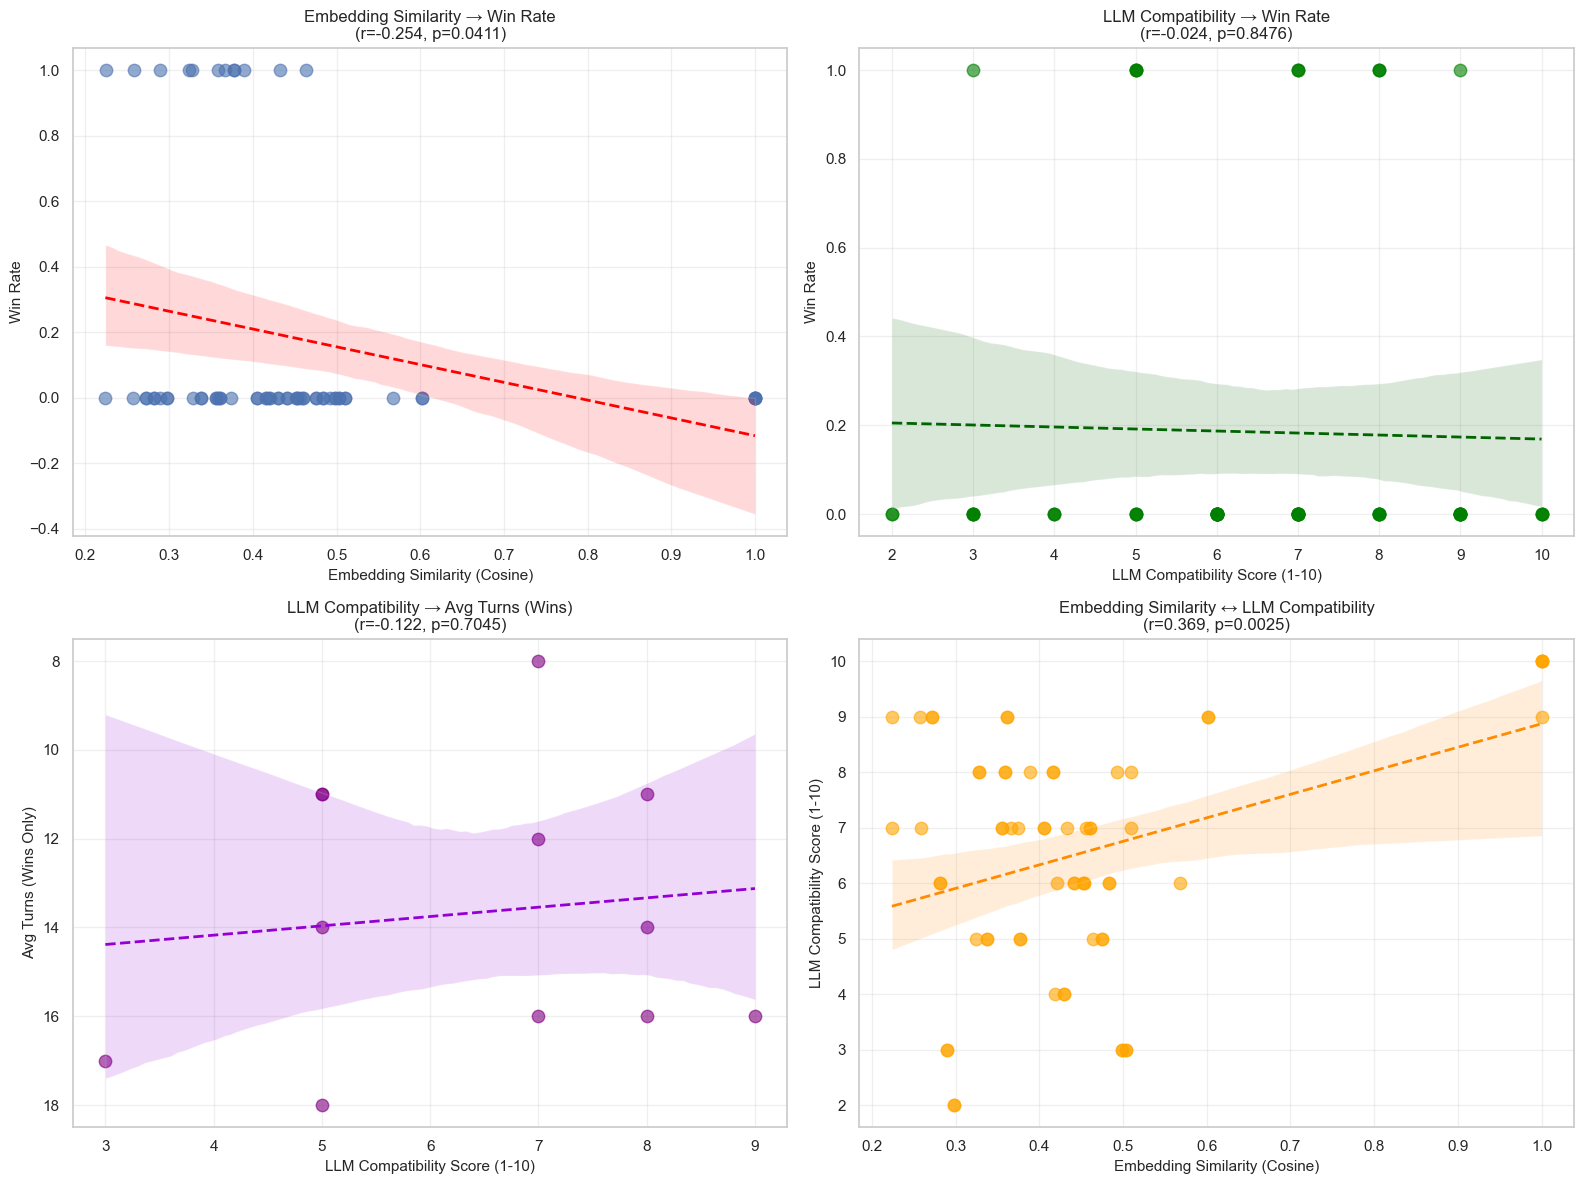

Saved visualization to: correlation_plots.png


In [31]:
# Create scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Embedding Similarity vs Win Rate
ax1 = axes[0, 0]
valid_data1 = analysis_df[['embedding_similarity', 'win_rate']].dropna()
ax1.scatter(valid_data1['embedding_similarity'], valid_data1['win_rate'], alpha=0.6, s=80)
sns.regplot(
    x='embedding_similarity',
    y='win_rate',
    data=valid_data1,
    ax=ax1,
    scatter=False,
    color='red',
    line_kws={'linestyle': '--', 'linewidth': 2}
)
ax1.set_xlabel('Embedding Similarity (Cosine)', fontsize=11)
ax1.set_ylabel('Win Rate', fontsize=11)
ax1.set_title(f'Embedding Similarity → Win Rate\n(r={correlation_results[0]["pearson_r"]:.3f}, p={correlation_results[0]["pearson_p"]:.4f})', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: LLM Compatibility vs Win Rate
ax2 = axes[0, 1]
valid_data2 = analysis_df[['compatibility_score', 'win_rate']].dropna()
ax2.scatter(valid_data2['compatibility_score'], valid_data2['win_rate'], alpha=0.6, s=80, color='green')
sns.regplot(
    x='compatibility_score',
    y='win_rate',
    data=valid_data2,
    ax=ax2,
    scatter=False,
    color='darkgreen',
    line_kws={'linestyle': '--', 'linewidth': 2}
)
ax2.set_xlabel('LLM Compatibility Score (1-10)', fontsize=11)
ax2.set_ylabel('Win Rate', fontsize=11)
ax2.set_title(f'LLM Compatibility → Win Rate\n(r={correlation_results[1]["pearson_r"]:.3f}, p={correlation_results[1]["pearson_p"]:.4f})', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Compatibility vs Avg Turns (Wins Only)
ax3 = axes[1, 0]
valid_data3 = analysis_df[['compatibility_score', 'avg_turns_wins_only']].dropna()
ax3.scatter(valid_data3['compatibility_score'], valid_data3['avg_turns_wins_only'], alpha=0.6, s=80, color='purple')
sns.regplot(
    x='compatibility_score',
    y='avg_turns_wins_only',
    data=valid_data3,
    ax=ax3,
    scatter=False,
    color='darkviolet',
    line_kws={'linestyle': '--', 'linewidth': 2}
)
ax3.set_xlabel('LLM Compatibility Score (1-10)', fontsize=11)
ax3.set_ylabel('Avg Turns (Wins Only)', fontsize=11)
ax3.set_title(f'LLM Compatibility → Avg Turns (Wins)\n(r={correlation_results[3]["pearson_r"]:.3f}, p={correlation_results[3]["pearson_p"]:.4f})', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()  # Lower turns = better

# Plot 4: Embedding Similarity vs LLM Compatibility
ax4 = axes[1, 1]
valid_data4 = analysis_df[['embedding_similarity', 'compatibility_score']].dropna()
ax4.scatter(valid_data4['embedding_similarity'], valid_data4['compatibility_score'], alpha=0.6, s=80, color='orange')
sns.regplot(
    x='embedding_similarity',
    y='compatibility_score',
    data=valid_data4,
    ax=ax4,
    scatter=False,
    color='darkorange',
    line_kws={'linestyle': '--', 'linewidth': 2}
)
ax4.set_xlabel('Embedding Similarity (Cosine)', fontsize=11)
ax4.set_ylabel('LLM Compatibility Score (1-10)', fontsize=11)
ax4.set_title(f'Embedding Similarity ↔ LLM Compatibility\n(r={correlation_results[5]["pearson_r"]:.3f}, p={correlation_results[5]["pearson_p"]:.4f})', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('correlation_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved visualization to: correlation_plots.png")

## 9. Special Analysis: Same vs Different Personas


SAME vs DIFFERENT PERSONA ANALYSIS

Same Persona Pairs (n=5):
  Win Rate: 0.000 ± 0.000
  Avg Turns (Wins): nan ± nan
  Embedding Similarity: 1.0000
  LLM Compatibility: 9.80

Different Persona Pairs (n=60):
  Win Rate: 0.200 ± 0.403
  Avg Turns (Wins): 13.67 ± 3.06
  Embedding Similarity: 0.3999
  LLM Compatibility: 6.25

t-test (Win Rate): t=-1.101, p=0.2752 (n.s.)


/var/folders/k0/fk1yjsp11fg_7yjml4xg3kmc0000gn/T/ipykernel_87890/899208861.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_to_plot, labels=['Same Persona', 'Different Persona'], patch_artist=True)
/var/folders/k0/fk1yjsp11fg_7yjml4xg3kmc0000gn/T/ipykernel_87890/899208861.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data_to_plot2, labels=['Same Persona', 'Different Persona'], patch_artist=True)


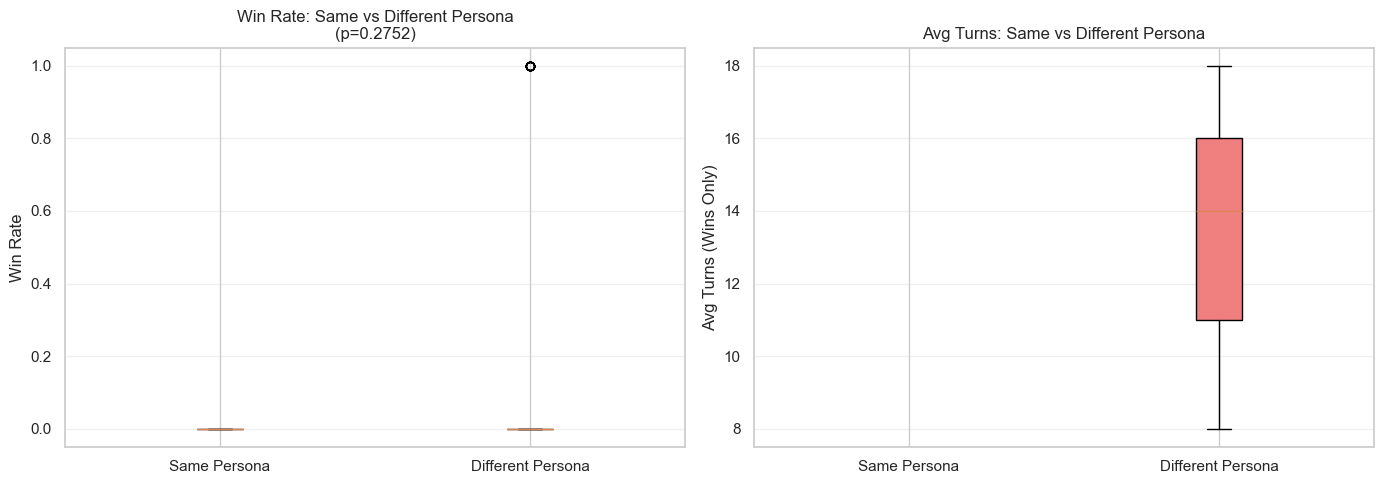


Saved comparison plot to: same_vs_different_persona.png


In [32]:
# Compare performance: same persona vs different personas
same_persona = analysis_df[analysis_df['is_same_persona'] == True]
diff_persona = analysis_df[analysis_df['is_same_persona'] == False]

print("\n" + "="*60)
print("SAME vs DIFFERENT PERSONA ANALYSIS")
print("="*60)

print(f"\nSame Persona Pairs (n={len(same_persona)}):")
print(f"  Win Rate: {same_persona['win_rate'].mean():.3f} ± {same_persona['win_rate'].std():.3f}")
print(f"  Avg Turns (Wins): {same_persona['avg_turns_wins_only'].mean():.2f} ± {same_persona['avg_turns_wins_only'].std():.2f}")
print(f"  Embedding Similarity: {same_persona['embedding_similarity'].mean():.4f}")
print(f"  LLM Compatibility: {same_persona['compatibility_score'].mean():.2f}")

print(f"\nDifferent Persona Pairs (n={len(diff_persona)}):")
print(f"  Win Rate: {diff_persona['win_rate'].mean():.3f} ± {diff_persona['win_rate'].std():.3f}")
print(f"  Avg Turns (Wins): {diff_persona['avg_turns_wins_only'].mean():.2f} ± {diff_persona['avg_turns_wins_only'].std():.2f}")
print(f"  Embedding Similarity: {diff_persona['embedding_similarity'].mean():.4f}")
print(f"  LLM Compatibility: {diff_persona['compatibility_score'].mean():.2f}")

# Statistical test (t-test)
from scipy.stats import ttest_ind

t_stat_wr, p_val_wr = ttest_ind(
    same_persona['win_rate'].dropna(),
    diff_persona['win_rate'].dropna()
)

print(f"\nt-test (Win Rate): t={t_stat_wr:.3f}, p={p_val_wr:.4f} {'***' if p_val_wr < 0.001 else '**' if p_val_wr < 0.01 else '*' if p_val_wr < 0.05 else '(n.s.)'}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Win Rate comparison
ax1 = axes[0]
data_to_plot = [same_persona['win_rate'].dropna(), diff_persona['win_rate'].dropna()]
bp1 = ax1.boxplot(data_to_plot, labels=['Same Persona', 'Different Persona'], patch_artist=True)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][1].set_facecolor('lightcoral')
ax1.set_ylabel('Win Rate', fontsize=12)
ax1.set_title(f'Win Rate: Same vs Different Persona\n(p={p_val_wr:.4f})', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Avg Turns comparison
ax2 = axes[1]
data_to_plot2 = [
    same_persona['avg_turns_wins_only'].dropna(),
    diff_persona['avg_turns_wins_only'].dropna()
]
bp2 = ax2.boxplot(data_to_plot2, labels=['Same Persona', 'Different Persona'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightblue')
bp2['boxes'][1].set_facecolor('lightcoral')
ax2.set_ylabel('Avg Turns (Wins Only)', fontsize=12)
ax2.set_title('Avg Turns: Same vs Different Persona', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('same_vs_different_persona.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved comparison plot to: same_vs_different_persona.png")